In [30]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use('seaborn-whitegrid')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

C:\Users\nicol\AppData\Local\Temp\ipykernel_11876\1233369388.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [31]:
# Some functions to help out with
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [32]:
# loading the dataset
SP500_stocks = pd.read_csv('SP500_stock_prices.csv')
# assign each different Sector string its own number
SP500_stocks['Sector'] = SP500_stocks['Sector'].map({'Consumer Discretionary': 0, 'Consumer Staples': 1, 'Energy': 2, 'Financials': 3, 'Health Care': 4, 'Industrials': 5, 'Information Technology': 6, 'Materials': 7, 'Real Estate': 8, 'Communication Services': 9, 'Utilities': 10})
SP500_stocks.head()

,Date,Ticker,Open,Low,High,Close,Volume,Sector
0,2016-01-04,MMM,148.050003,145.399994,148.320007,146.820007,3277200,5
1,2016-01-05,MMM,146.820007,145.610001,147.500000,147.460007,2688100,5
2,2016-01-06,MMM,145.589996,143.419998,145.759995,144.490005,2997100,5
3,2016-01-07,MMM,142.520004,140.630005,143.130005,140.970001,3553500,5
4,2016-01-08,MMM,141.360001,140.220001,142.500000,140.490005,2664000,5


In [40]:
# getting companyList
stockList = SP500_stocks['Ticker'].unique()[0:10]
# getting the data for each company
df_ = {}

for stock in stockList:
    df_[stock] = SP500_stocks[SP500_stocks['Ticker'] == stock]
    # remove the Ticker column
    df_[stock] = df_[stock].drop(['Ticker'], axis=1)
    # set the date as the index
    df_[stock] = df_[stock].set_index('Date')

# remove dates past february 2020
#for stock in stockList:
    #df_[stock] = df_[stock].loc[:'2020-04-02']

df_

{'MMM':                   Open         Low        High       Close   Volume  Sector
 Date                                                                       
 2016-01-04  148.050003  145.399994  148.320007  146.820007  3277200       5
 2016-01-05  146.820007  145.610001  147.500000  147.460007  2688100       5
 2016-01-06  145.589996  143.419998  145.759995  144.490005  2997100       5
 2016-01-07  142.520004  140.630005  143.130005  140.970001  3553500       5
 2016-01-08  141.360001  140.220001  142.500000  140.490005  2664000       5
 ...                ...         ...         ...         ...      ...     ...
 2020-03-26  131.789993  130.610001  136.380005  136.179993  6717000       5
 2020-03-27  132.830002  130.910004  137.070007  133.240005  4262300       5
 2020-03-30  132.250000  131.059998  138.009995  137.740005  3869500       5
 2020-03-31  135.690002  135.679993  139.440002  136.509995  3613700       5
 2020-04-01  132.000000  131.009995  135.839996  133.139999  3777600 

In [41]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for stock in stockList:
    df_new[stock] = {}
    df_new[stock]["Train"], df_new[stock]["Test"] = split(df_[stock], "2019-06-01", ["Close"])

In [6]:
df_new

{'MMM': {'Train':                  Close
  Date                  
  2016-01-04  146.820007
  2016-01-05  147.460007
  2016-01-06  144.490005
  2016-01-07  140.970001
  2016-01-08  140.490005
  ...                ...
  2019-05-24  166.089996
  2019-05-28  163.350006
  2019-05-29  161.399994
  2019-05-30  160.580002
  2019-05-31  159.750000
  
  [858 rows x 1 columns],
  'Test':                  Close
  Date                  
  2019-06-03  160.039993
  2019-06-04  164.289993
  2019-06-05  163.850006
  2019-06-06  164.720001
  2019-06-07  166.610001
  ...                ...
  2020-03-26  136.179993
  2020-03-27  133.240005
  2020-03-30  137.740005
  2020-03-31  136.509995
  2020-04-01  133.139999
  
  [211 rows x 1 columns]},
 'AOS': {'Train':                 Close
  Date                 
  2016-01-04  37.590000
  2016-01-05  37.380001
  2016-01-06  36.639999
  2016-01-07  34.849998
  2016-01-08  33.610001
  ...               ...
  2019-05-24  44.029999
  2019-05-28  43.049999
  2019-05-2

We plot all companies we pick and paint which one is the training set and test set

Error in callback <function _draw_all_if_interactive at 0x000001A5BE402710> (for post_execute):


KeyboardInterrupt: 

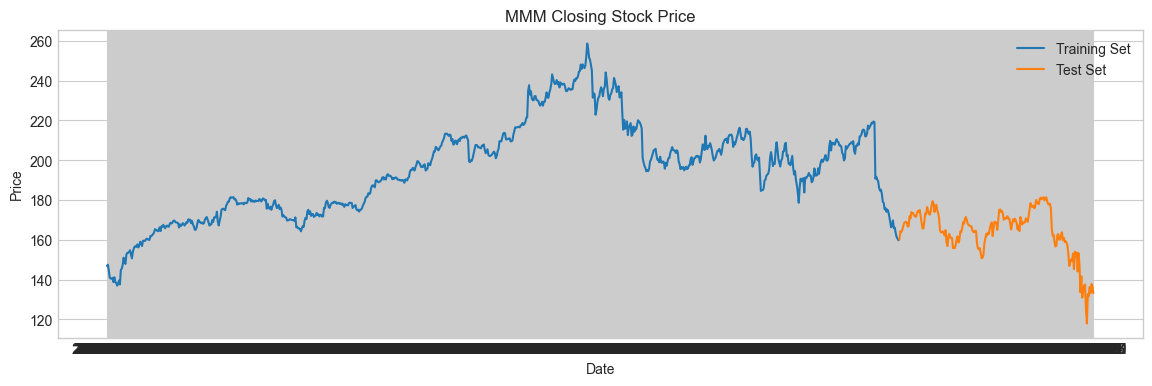

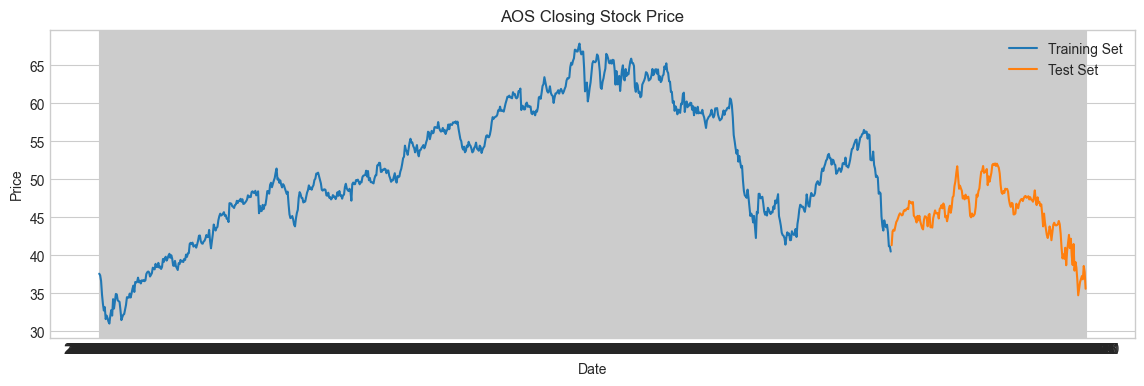

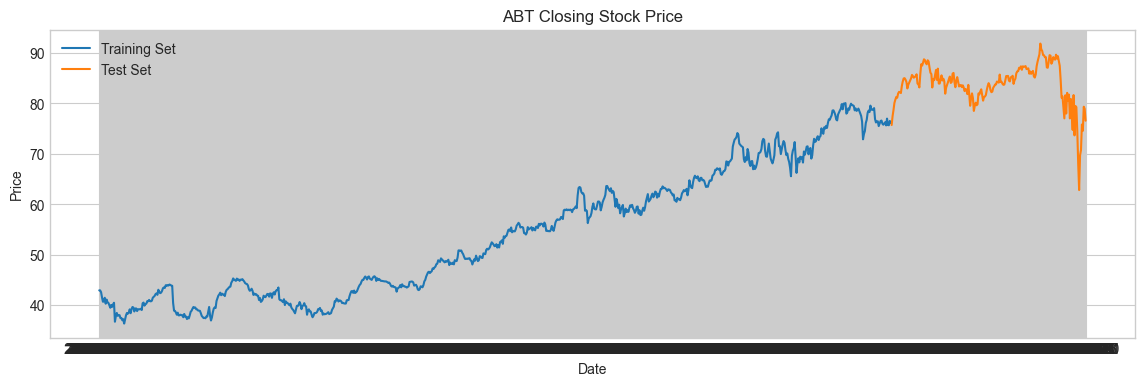

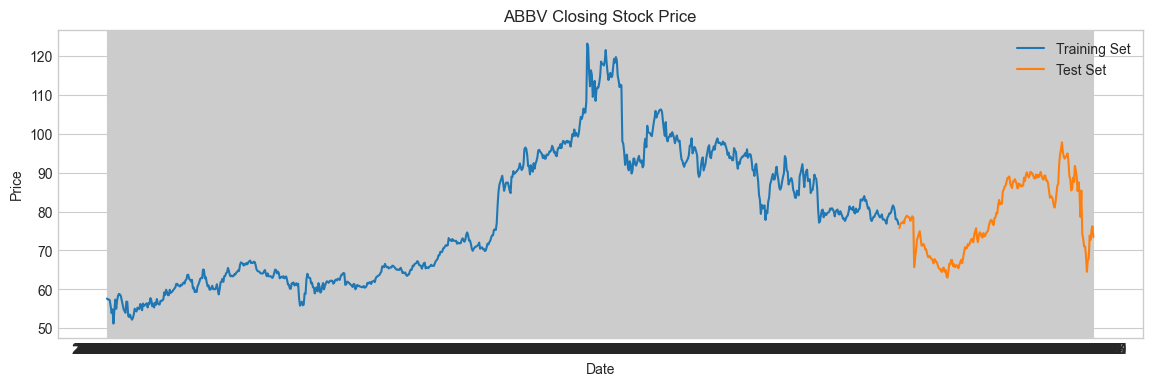

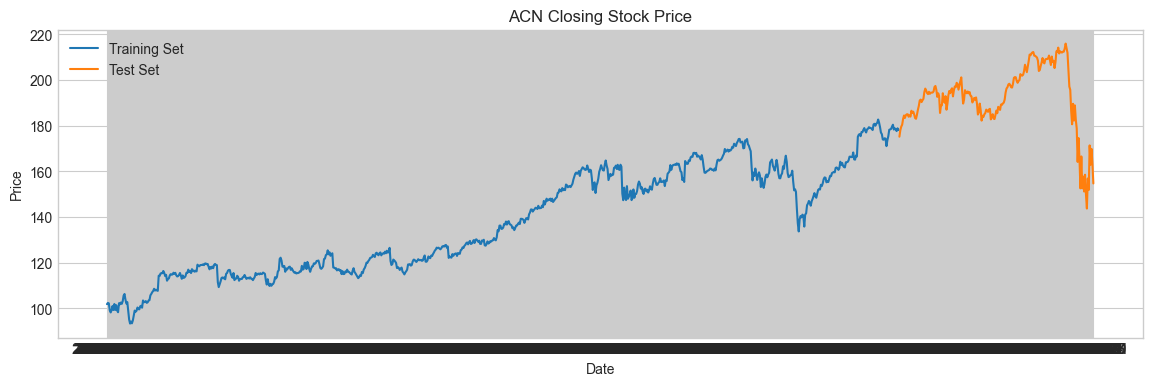

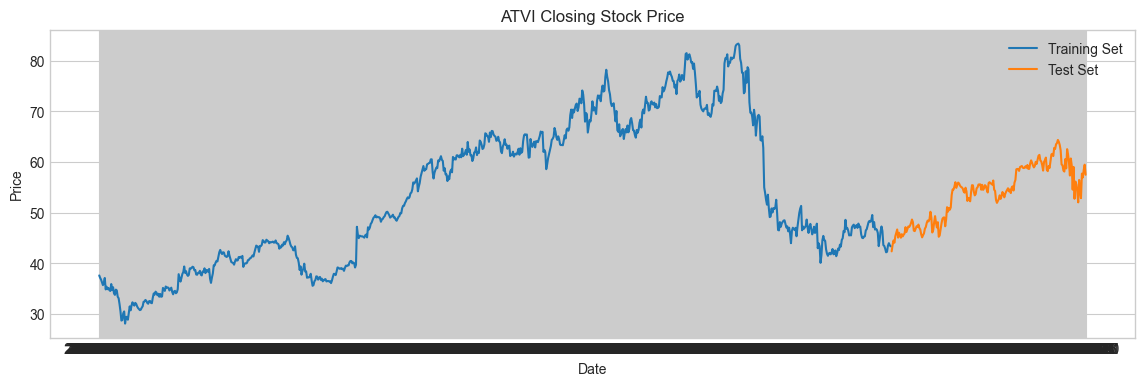

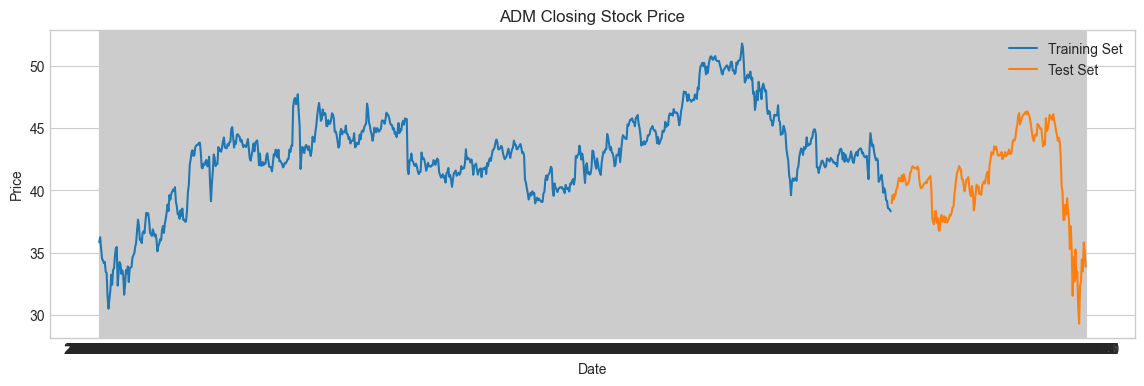

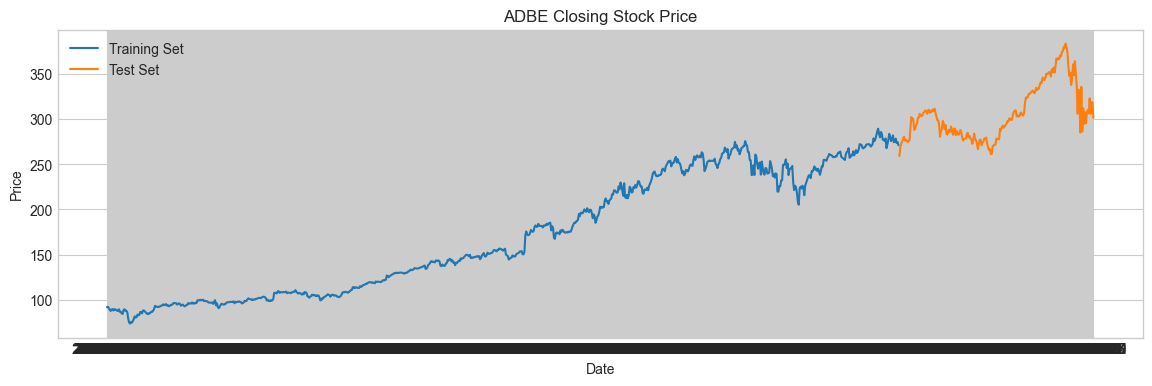

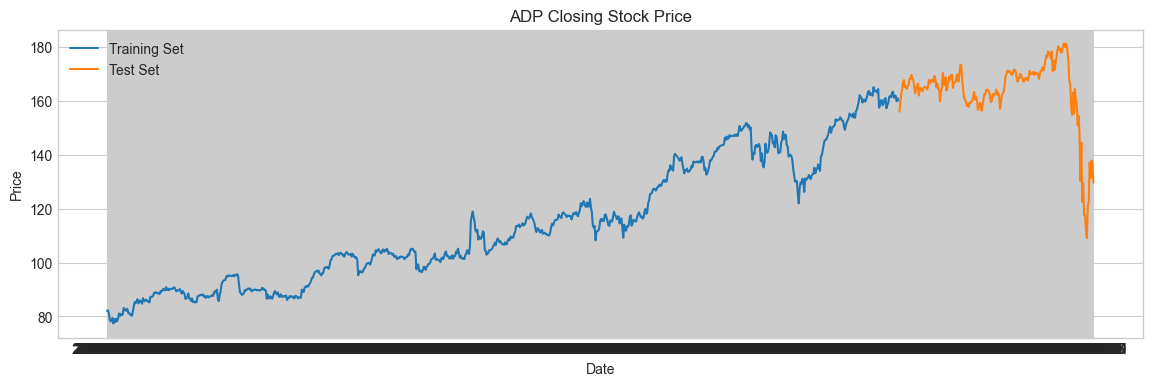

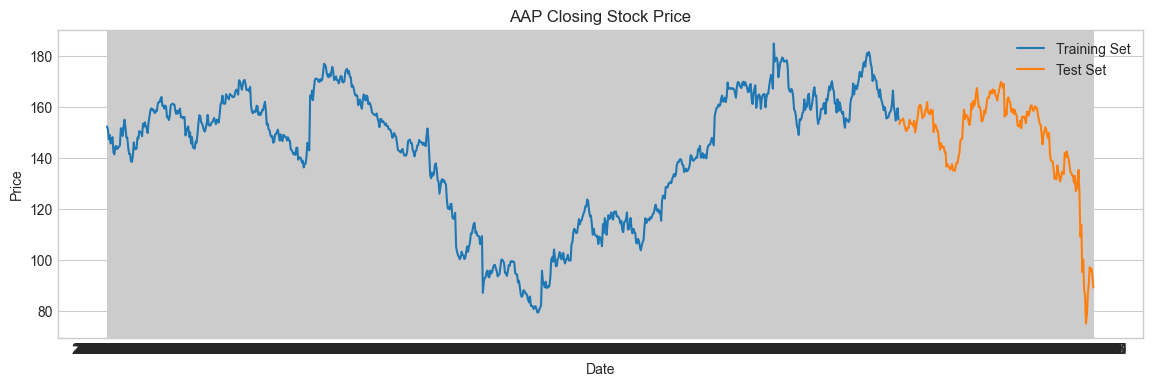

In [35]:
for i in stockList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

We rescale all stock price to zero for the lowest and 1 for the highest.
Each of the companies have their own scale. We make another two dictionaries which contain the scaled price for each company.
One contains train set and the other the test set.

We also create another dictionary for collecting the scaler. This will be useful when we want to inverse transform our prediction.

In [42]:



# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc
    
del a0
del a1

We print the shape of our transformed set. A few of the companies have more than others. We will make the input be uniform for each stock ticker in terms of shape.

In [43]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")    
for i in transform_test.keys():
    print(i, transform_test[i].shape)

MMM (858, 1)
AOS (858, 1)
ABT (858, 1)
ABBV (858, 1)
ACN (858, 1)
ATVI (858, 1)
ADM (858, 1)
ADBE (858, 1)
ADP (858, 1)
AAP (858, 1)


MMM (211, 1)
AOS (211, 1)
ABT (211, 1)
ABBV (211, 1)
ACN (211, 1)
ATVI (211, 1)
ADM (211, 1)
ADBE (211, 1)
ADP (211, 1)
AAP (211, 1)


60 features should be enough for training. We prepare the shape for the NN.

In [11]:
trainset = {}
testset = {}
# We will define a variable for how long we look back to predict the next value
# We will use 90 days
look_back = 90
for j in stockList:
    trainset[j] = {}
    X_train = []
    y_train = []

    for i in range(look_back,858):
        X_train.append(transform_train[j][i-look_back:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train
    
    testset[j] = {}
    X_test = []
    y_test = []    
    for i in range(look_back, 147):
        X_test.append(transform_test[j][i-look_back:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test

Check shape one last time before training

In [12]:
arr_buff = []
for i in stockList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

,X_train,y_train,X_test,y_test
MMM,"(768, 90, 1)","(768,)","(57, 90, 1)","(57,)"
AOS,"(768, 90, 1)","(768,)","(57, 90, 1)","(57,)"
ABT,"(768, 90, 1)","(768,)","(57, 90, 1)","(57,)"
ABBV,"(768, 90, 1)","(768,)","(57, 90, 1)","(57,)"
ACN,"(768, 90, 1)","(768,)","(57, 90, 1)","(57,)"
ATVI,"(768, 90, 1)","(768,)","(57, 90, 1)","(57,)"
ADM,"(768, 90, 1)","(768,)","(57, 90, 1)","(57,)"
ADBE,"(768, 90, 1)","(768,)","(57, 90, 1)","(57,)"
ADP,"(768, 90, 1)","(768,)","(57, 90, 1)","(57,)"
AAP,"(768, 90, 1)","(768,)","(57, 90, 1)","(57,)"


The LSTM model

In [13]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in stockList:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=15, batch_size=200)

Fitting to MMM
Epoch 1/15
4/4 [==============================] - 9s 554ms/step - loss: 0.1346
Epoch 2/15
4/4 [==============================] - 2s 531ms/step - loss: 0.0299
Epoch 3/15
4/4 [==============================] - 2s 497ms/step - loss: 0.0224
Epoch 4/15
4/4 [==============================] - 2s 493ms/step - loss: 0.0315
Epoch 5/15
4/4 [==============================] - 2s 509ms/step - loss: 0.0323
Epoch 6/15
4/4 [==============================] - 2s 524ms/step - loss: 0.0209
Epoch 7/15
4/4 [==============================] - 2s 516ms/step - loss: 0.0274
Epoch 8/15
4/4 [==============================] - 2s 537ms/step - loss: 0.0250
Epoch 9/15
4/4 [==============================] - 2s 526ms/step - loss: 0.0272
Epoch 10/15
4/4 [==============================] - 2s 491ms/step - loss: 0.0180
Epoch 11/15
4/4 [==============================] - 2s 512ms/step - loss: 0.0284
Epoch 12/15
4/4 [==============================] - 2s 508ms/step - loss: 0.0156
Epoch 13/15
4/4 [=================

Visualizing predictions:

2/2 [==============================] - 0s 36ms/step


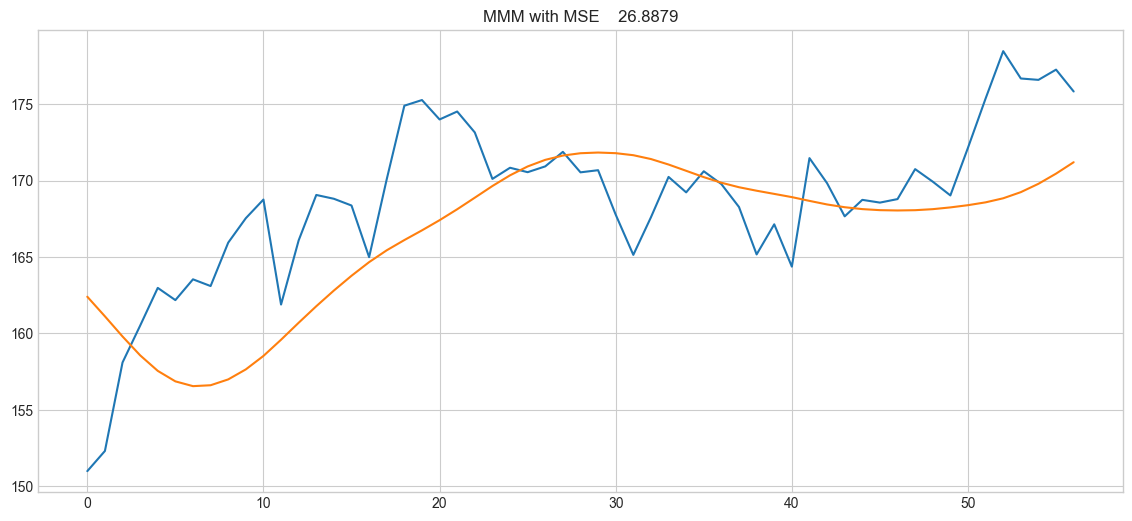

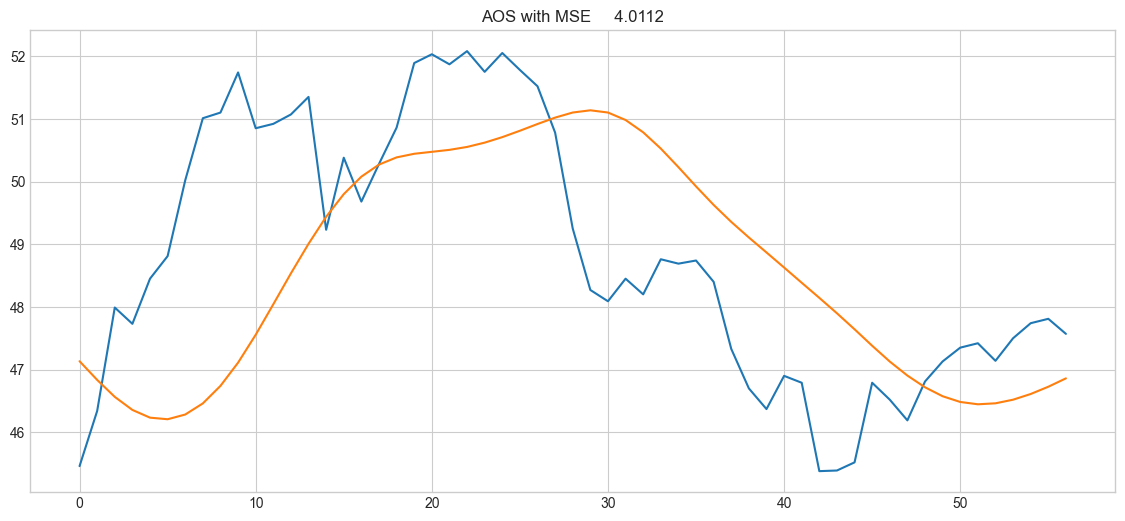

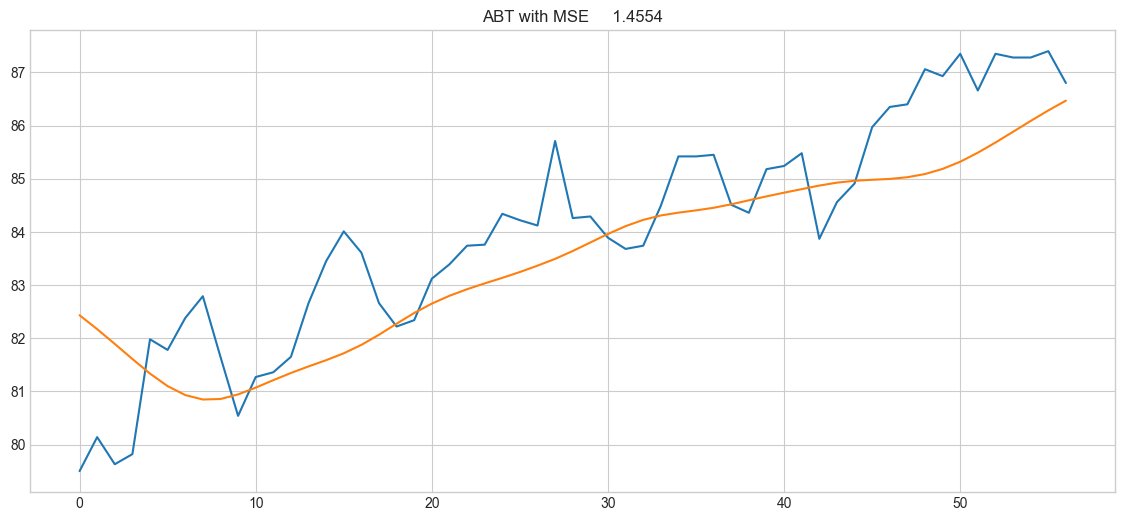

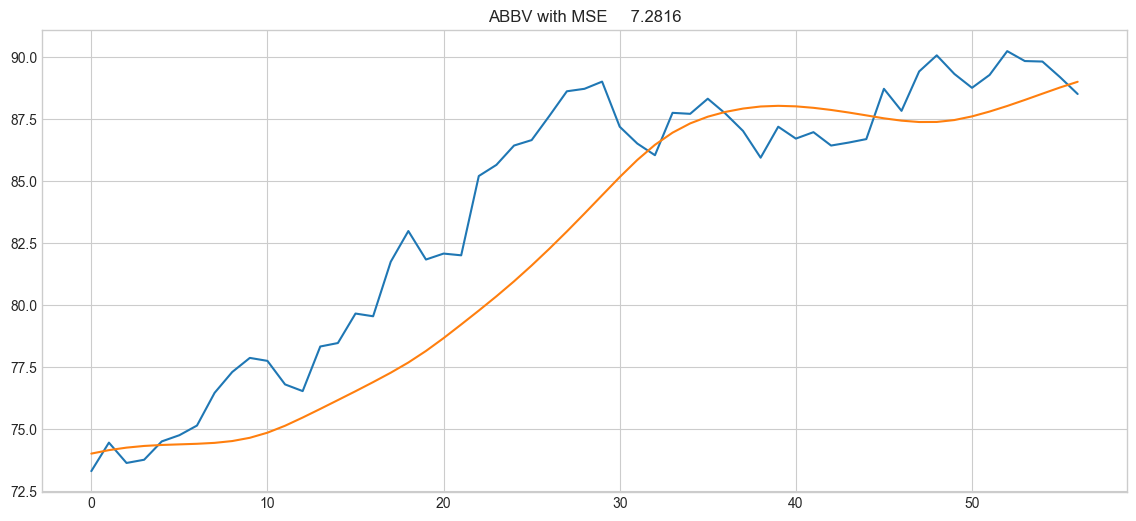

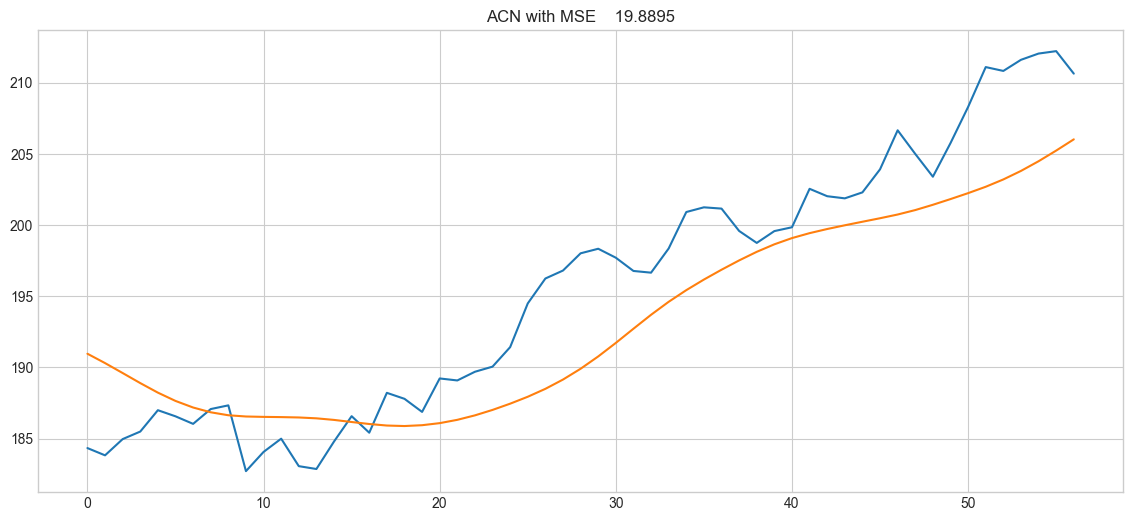

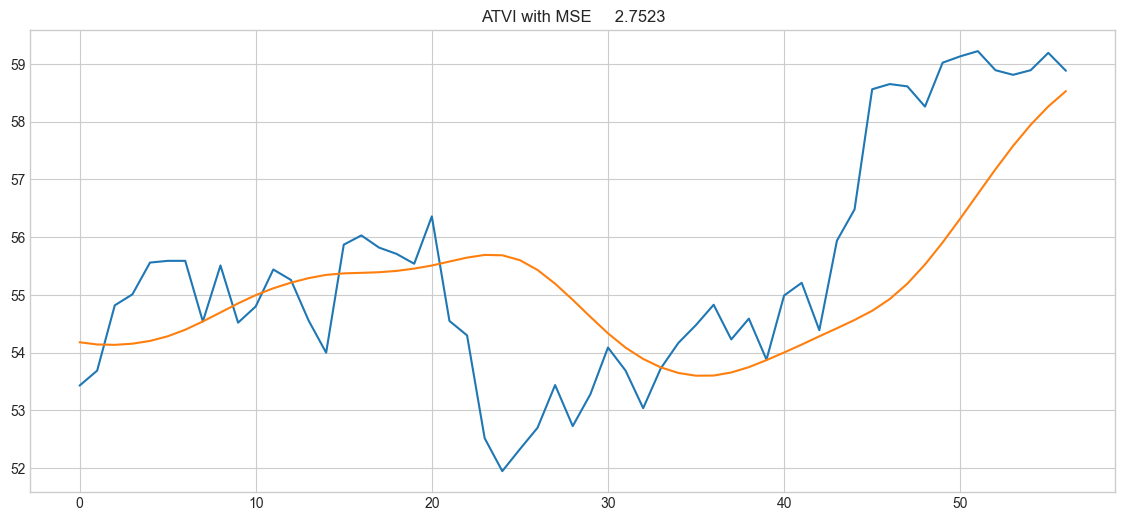

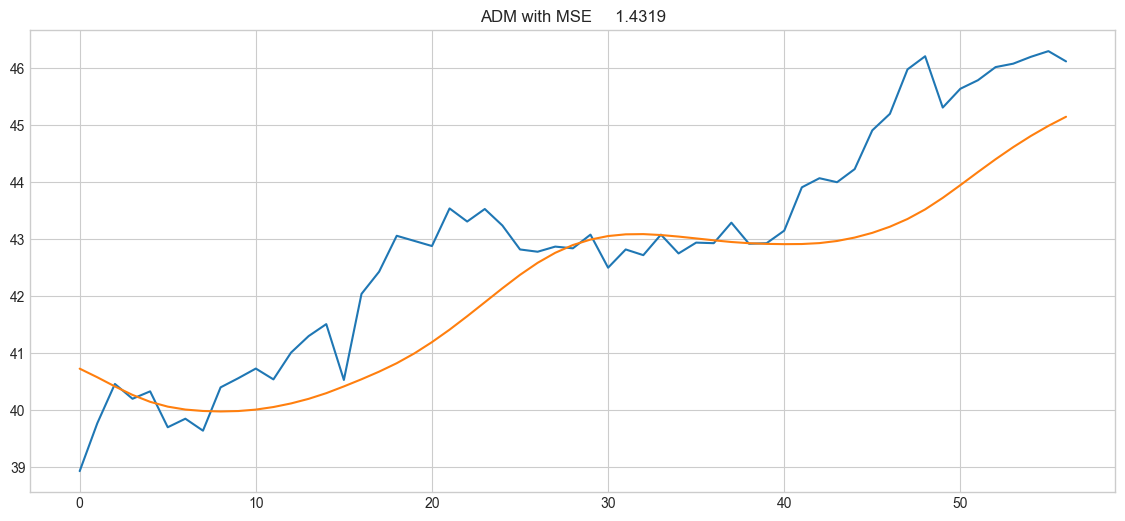

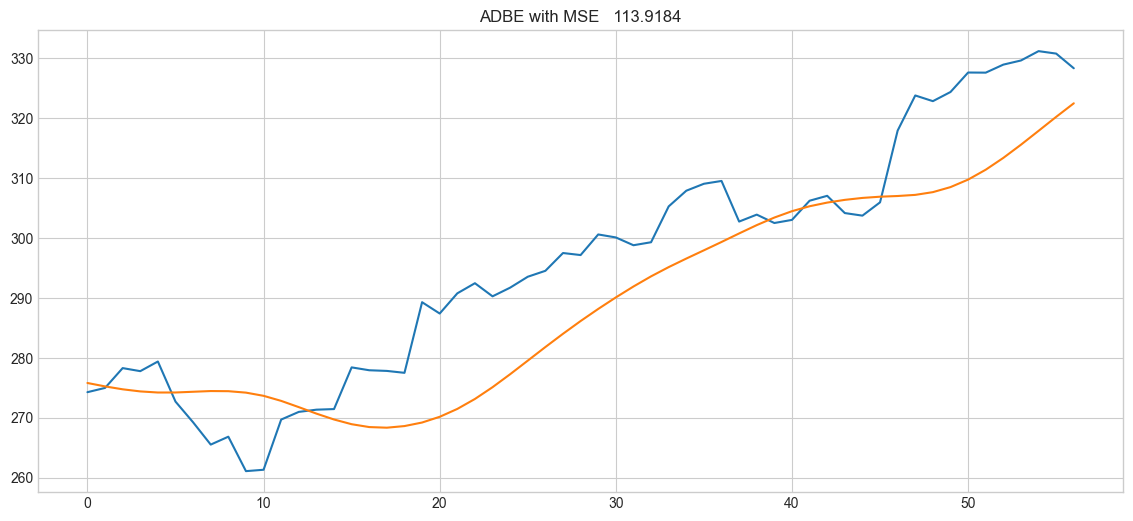

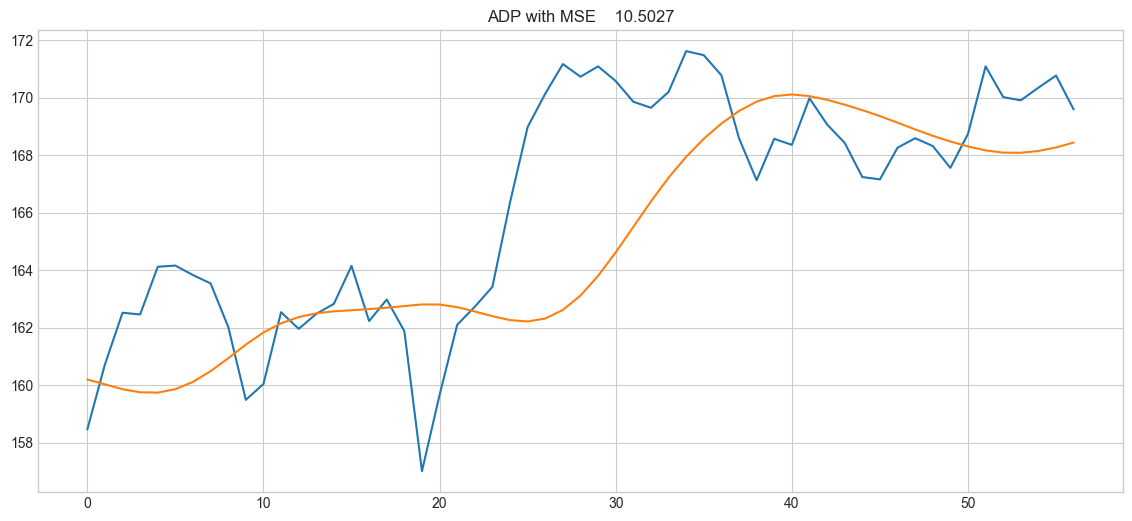

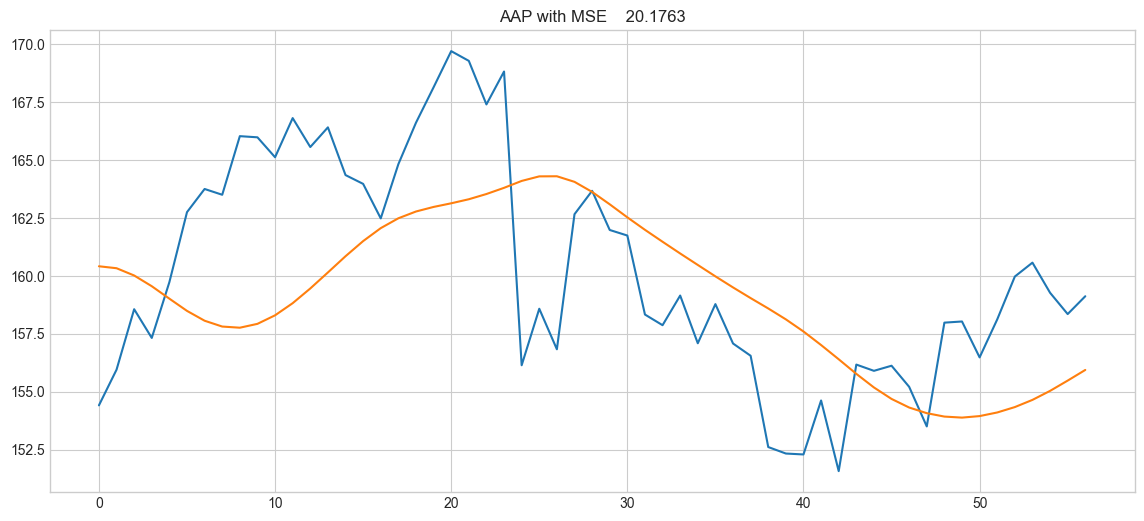

In [20]:
pred_result = {}
for i in stockList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

The prediction can be improved by introducing shifting/lagging. Essentially we slide our prediction for a period of time. This is a common practice in the signal processing subfield.


In [1]:
time_index = df_new["MMM"]["Test"][look_back:].index
def lagging(df, lag, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    df_pred_lag = df_pred.shift(lag)
    
    print("MSE without Lag", mean_squared_error(np.array(df_true), np.array(df_pred)))
    print("MSE with Lag 5", mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5])))

    plt.figure(figsize=(14,4))
    plt.title("Prediction without Lag")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.plot(df_true)
    plt.plot(df_pred)

    MSE_lag = mean_squared_error(np.array(df_true[:-5]), np.array(df_pred_lag[:-5]))
    return df_pred_lag
    plt.figure(figsize=(14,4))
    plt.title("Prediction with Lag")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.plot(df_true)
    plt.plot(df_pred_lag)

NameError: name 'df_new' is not defined

In [ ]:

lagging(pred_result["MMM"], -5, time_index)

ValueError: Length of values (57) does not match length of index (121)

In [2]:
pred_result

NameError: name 'pred_result' is not defined

In [3]:
# extract the predicted values and true values from the dictionary pred_result and store them in a dataframe
df_pred = pd.DataFrame()
df_true = pd.DataFrame()
for i in stockList:
    df_pred[i] = pred_result[i]["Pred"].reshape(-1)
    df_true[i] = pred_result[i]["True"].reshape(-1)
df = pd.concat([df_pred, df_true], axis=1)
# make header for predicted and true values
df.columns = [i+"_pred" for i in stockList] + [i+"_true" for i in stockList]
df.head()


NameError: name 'pd' is not defined

In [4]:
# Calculate the daily returns for each stock using the predicted and true values:
df_returns_pred = df_pred.pct_change().dropna()
df_returns_true = df_true.pct_change().dropna()
# print(df_returns_pred, df_returns_true)
# # Calculate the expected returns and covariance matrix of the returns:
# mean_returns_pred = df_returns_pred.mean()
# mean_returns_true = df_returns_true.mean()
# cov_matrix_pred = df_returns_pred.cov()
# cov_matrix_true = df_returns_true.cov()

# Define a function to calculate the portfolio returns and risk for a given set of weights:
# def portfolio_performance(weights, mean_returns, cov_matrix):
#     returns = np.sum(mean_returns * weights) * 252
#     risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
#     return returns, risk
    

NameError: name 'df_pred' is not defined

In [5]:
import numpy as np
from scipy.optimize import minimize

# Calculate expected returns and covariance matrix
mu = df_pred.mean().values
Sigma = df_pred.cov().values

# Define variables
n_assets = len(mu)
w = np.ones(n_assets) / n_assets

# Define objective function
def objective(w):
    return np.dot(np.dot(w, Sigma), w)

# Define constraints
cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: x}]

# Solve optimization problem for a range of target returns
target_returns = np.linspace(mu.min(), mu.max(), num=100)
risk_data = []
ret_data = []
for tr in target_returns:
    # Define new constraints
    cons_new = cons + [{'type': 'ineq', 'fun': lambda x: tr - np.dot(mu, x)}]

    # Solve optimization problem
    res = minimize(objective, w, method='SLSQP', constraints=cons_new)
    if res.success:
        # Save results
        ret_data.append(tr)
        risk_data.append(np.sqrt(objective(res.x)))
    else:
        print('Optimization failed for target return:', tr)

# Calculate efficient frontier
ef = pd.DataFrame({'ret': ret_data, 'risk': risk_data})
ef.set_index('ret', inplace=True)

# Select optimal portfolio for max return
# max_ret = ef['risk'].idxmin()
max_ret = 10
res = minimize(objective, w, method='SLSQP', constraints=cons + [{'type': 'eq', 'fun': lambda x: objective(x) - max_ret}])

if res.success:
    weights = res.x
    # Select top 5 stocks
    top5_idx = np.argsort(weights)[-5:]
    top5_stocks = df_pred.columns[top5_idx]
else:
    print('Optimization failed for max return:', max_ret)



NameError: name 'df_pred' is not defined

In [ ]:
# DET HER ER EN MEGET STOR PROTOTYPE... IKKE SE DEN SOM OFFICIEL ENDNU!!!
# for the top 5 stocks in the portfolio, we want to extract them and make a new dataframe with the predicted values
# and true values for the top 5 stocks
df_top5 = pd.DataFrame()
for i in top5_stocks:
    df_top5[i+"_pred"] = df_pred[i]
    df_top5[i+"_true"] = df_true[i]
df_top5.head()

# change the prices to returns in percent
df_top5_returns = df_top5.pct_change().dropna() * 100
df_top5_returns.head()

# calculate the mean returns and covariance matrix
mean_returns = df_top5_returns.mean()
cov_matrix = df_top5_returns.cov()
print(mean_returns)
print(cov_matrix)

# set up the optimal weights for the portfolio
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# extract the true values from the dataframe
df_top5_true = df_top5.iloc[:, 5:]
df_top5_true.head()

# calculate the portfolio returns
mean_returns = df_top5_true.mean()

portfolio_returns = mean_returns.dot(weights)
portfolio_returns







ABT_pred     0.085520
ABT_true     0.160449
ADM_pred     0.184511
ADM_true     0.308388
ATVI_pred    0.138440
ATVI_true    0.182869
AOS_pred    -0.009218
AOS_true     0.091365
AAP_pred    -0.050162
AAP_true     0.066905
dtype: float64
           ABT_pred  ABT_true  ADM_pred  ADM_true  ATVI_pred  ATVI_true  \
ABT_pred   0.023933 -0.027699  0.031742 -0.007178   0.003005  -0.034387   
ABT_true  -0.027699  0.703868 -0.010729 -0.067818   0.002286   0.272235   
ADM_pred   0.031742 -0.010729  0.072303 -0.028693   0.021402  -0.076746   
ADM_true  -0.007178 -0.067818 -0.028693  1.080982   0.018903  -0.165847   
ATVI_pred  0.003005  0.002286  0.021402  0.018903   0.106355  -0.022595   
ATVI_true -0.034387  0.272235 -0.076746 -0.165847  -0.022595   1.892017   
AOS_pred   0.028794 -0.022148  0.044130 -0.018366   0.004105  -0.123718   
AOS_true  -0.076213  0.268387 -0.066553  0.000796   0.085270   0.640915   
AAP_pred   0.019588 -0.002115  0.040252  0.013432   0.026447  -0.074960   
AAP_true  -0.03

94.44880885074014

In [30]:
top5_stocks
# Calculate expected returns in % for the top 5 stocks
mu[top5_idx]
# show true returns for the top 5 stocks
df_true[top5_stocks].mean().values
print("The top 5 stocks are: ", top5_stocks)
print("The expected returns for the top 5 stocks are: ", mu[top5_idx])
print("The true returns for the top 5 stocks are: ", df_true[top5_stocks].mean().values)


The top 5 stocks are:  Index(['ABT', 'ADM', 'ATVI', 'AOS', 'AAP'], dtype='object')
The expected returns for the top 5 stocks are:  [ 83.46828   42.14238   55.068634  48.584846 159.20955 ]
The true returns for the top 5 stocks are:  [ 84.02491238  42.89210544  55.42631571  48.81087721 160.21245588]


In [34]:
# determine which stocks have the best prediction and which have the best performances in terms of stock price change

# weigh the prediction and the performance to find the best 5 stocks to invest in
# the weight of the prediction is 0.7 and the weight of the performance is 0.3
# the best stock is the one with the highest score
best5_weighted = sorted(pred_result.items(), key=lambda x: 0.1*mean_squared_error(x[1]["True"], x[1]["Pred"]) + 20*(x[1]["Pred"][-1] - x[1]["Pred"][0]))[:5]

# only pick the ticker name of the best 5 stocks
best5_weighted = [i[0] for i in best5_weighted]
best5_weighted

['AAP', 'AOS', 'ABT', 'ATVI', 'ADM']

In [35]:
# calculating the actual stock price change in percent for the best 5 stocks
best5_weighted_change = {}
for i in best5_weighted:
    best5_weighted_change[i] = (pred_result[i]["True"][-1] - pred_result[i]["True"][0])/pred_result[i]["True"][0]*100

# print the best 5 stocks to invest in
print("The best 5 stocks to invest in are:", best5_weighted)


best5_weighted_change

The best 5 stocks to invest in are: ['AAP', 'AOS', 'ABT', 'ATVI', 'ADM']


{'AAP': array([3.05031497]),
 'AOS': array([4.64144446]),
 'ABT': array([9.18239378]),
 'ATVI': array([10.20026339]),
 'ADM': array([18.46904334])}

Brug CAPM (Capital Asset P. Management Model)

test

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Load the data
df = pd.read_csv('SP500_stock_prices.csv')
# only keep AAPL
df = df[df['Ticker'] == 'AAPL']
# make sector categorical with numbers
df['Sector'] = df['Sector'].astype('category').cat.codes
# make date to datetime
df['Date'] = pd.to_datetime(df['Date'])
# make the date the index
df.set_index('Date', inplace=True)
df

,Ticker,Open,Low,High,Close,Volume,Sector
Date,,,,,,,
2016-01-04,AAPL,25.652500,25.500000,26.342501,26.337500,270597600,0
2016-01-05,AAPL,26.437500,25.602501,26.462500,25.677500,223164000,0
2016-01-06,AAPL,25.139999,24.967501,25.592501,25.174999,273829600,0
2016-01-07,AAPL,24.670000,24.107500,25.032499,24.112499,324377600,0
2016-01-08,AAPL,24.637501,24.190001,24.777500,24.240000,283192000,0
...,...,...,...,...,...,...,...
2020-03-26,AAPL,61.630001,61.590000,64.669998,64.610001,252087200,0
2020-03-27,AAPL,63.187500,61.762501,63.967499,61.935001,204216800,0
2020-03-30,AAPL,62.685001,62.349998,63.880001,63.702499,167976400,0


In [17]:
# Select the features to use as inputs
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Sector']
df = df[features]


# Normalize the data
scaler = MinMaxScaler()
df[features[:-1]] = scaler.fit_transform(df[features[:-1]])


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [19]:
# split the data into training and testing sets
# Define the specific date to split the DataFrame
split_date = pd.to_datetime('2020-01-01')

# Split the DataFrame into training and test sets based on the specific date
train_data = df.loc[df.index < split_date]
test_data = df.loc[df.index >= split_date]

In [20]:
# Create input sequences for the model
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(seq_length, len(data)):
        x = data.iloc[i-seq_length:i][features[:-1]].values
        y = data.iloc[i]['Close']
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 30
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [21]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(seq_length, len(features)-1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))


Epoch 1/100
31/31 [==============================] - 3s 30ms/step - loss: 0.0127 - val_loss: 0.0052
Epoch 2/100
31/31 [==============================] - 0s 12ms/step - loss: 9.4387e-04 - val_loss: 0.0053
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 6.5264e-04 - val_loss: 0.0043
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 5.8289e-04 - val_loss: 0.0047
Epoch 5/100
31/31 [==============================] - 0s 13ms/step - loss: 5.4815e-04 - val_loss: 0.0049
Epoch 6/100
31/31 [==============================] - 0s 13ms/step - loss: 5.0160e-04 - val_loss: 0.0062
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 4.9550e-04 - val_loss: 0.0063
Epoch 8/100
31/31 [==============================] - 0s 13ms/step - loss: 4.8387e-04 - val_loss: 0.0055
Epoch 9/100
31/31 [==============================] - 0s 14ms/step - loss: 4.5879e-04 - val_loss: 0.0070
Epoch 10/100
31/31 [==============================] - 0s 13ms/step -

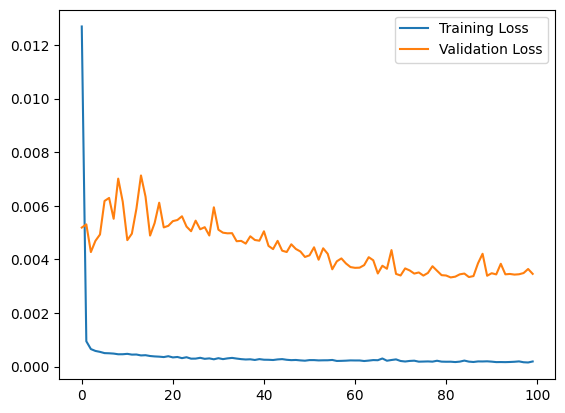

In [22]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [23]:
# Make predictions on the test data
y_pred = model.predict(X_test)


2/2 [==============================] - 0s 4ms/step


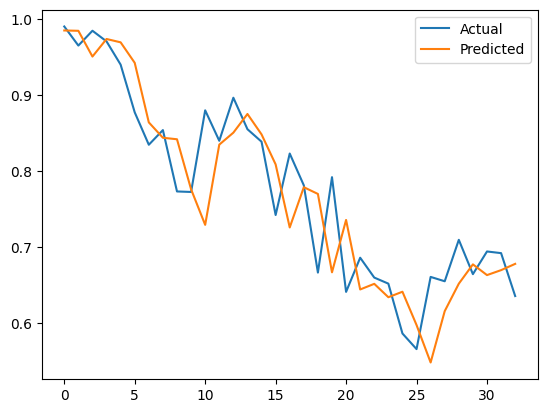

In [24]:
# Plot the actual vs predicted prices
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


In [48]:
trainset = {}
testset = {}


#We will define a variable for how long we look back to predict the next value
# We will use 60 days
look_back = 90
look_forward = 30

for j in stockList:
    trainset[j] = {}
    X_train = []
    y_train = []

    for i in range(look_back, len(transform_train[j])-look_forward):
        X_train.append(transform_train[j][i-look_back:i])
        y_train.append(transform_train[j][i+look_forward])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    trainset[j]["y"] = y_train

    testset[j] = {}
    X_test = []
    y_test = []
    for i in range(look_back, len(transform_test[j])-look_forward):
        X_test.append(transform_test[j][i-look_back:i])
        y_test.append(transform_test[j][i+look_forward])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], X_train.shape[2]))
    testset[j]["y"] = y_test


In [49]:
arr_buff = []
for i in stockList:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockList)

,X_train,y_train,X_test,y_test
MMM,"(738, 90, 1)","(738, 1)","(91, 90, 1)","(91, 1)"
AOS,"(738, 90, 1)","(738, 1)","(91, 90, 1)","(91, 1)"
ABT,"(738, 90, 1)","(738, 1)","(91, 90, 1)","(91, 1)"
ABBV,"(738, 90, 1)","(738, 1)","(91, 90, 1)","(91, 1)"
ACN,"(738, 90, 1)","(738, 1)","(91, 90, 1)","(91, 1)"
ATVI,"(738, 90, 1)","(738, 1)","(91, 90, 1)","(91, 1)"
ADM,"(738, 90, 1)","(738, 1)","(91, 90, 1)","(91, 1)"
ADBE,"(738, 90, 1)","(738, 1)","(91, 90, 1)","(91, 1)"
ADP,"(738, 90, 1)","(738, 1)","(91, 90, 1)","(91, 1)"
AAP,"(738, 90, 1)","(738, 1)","(91, 90, 1)","(91, 1)"


In [51]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in stockList:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=100, batch_size=200)

Fitting to MMM
Epoch 1/100
4/4 [==============================] - 6s 244ms/step - loss: 0.1412
Epoch 2/100
4/4 [==============================] - 1s 221ms/step - loss: 0.0358
Epoch 3/100
4/4 [==============================] - 1s 237ms/step - loss: 0.0316
Epoch 4/100
4/4 [==============================] - 1s 266ms/step - loss: 0.0305
Epoch 5/100
4/4 [==============================] - 1s 262ms/step - loss: 0.0240
Epoch 6/100
4/4 [==============================] - 1s 244ms/step - loss: 0.0251
Epoch 7/100
4/4 [==============================] - 1s 262ms/step - loss: 0.0231
Epoch 8/100
4/4 [==============================] - 1s 251ms/step - loss: 0.0464
Epoch 9/100
4/4 [==============================] - 1s 254ms/step - loss: 0.0244
Epoch 10/100
4/4 [==============================] - 1s 253ms/step - loss: 0.0225
Epoch 11/100
4/4 [==============================] - 1s 258ms/step - loss: 0.0252
Epoch 12/100
4/4 [==============================] - 1s 254ms/step - loss: 0.0320
Epoch 13/100
4/4 [====

3/3 [==============================] - 0s 19ms/step


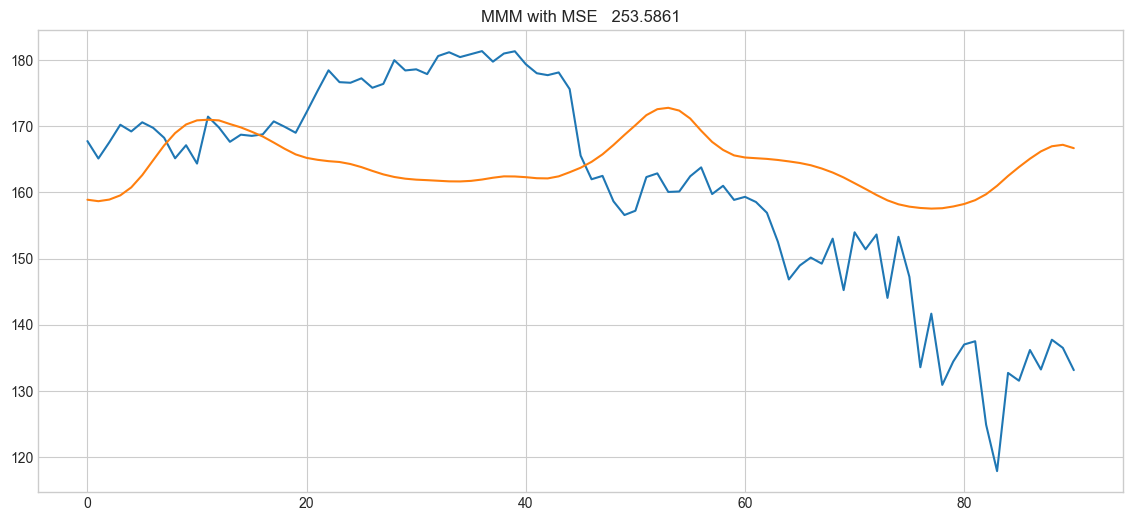

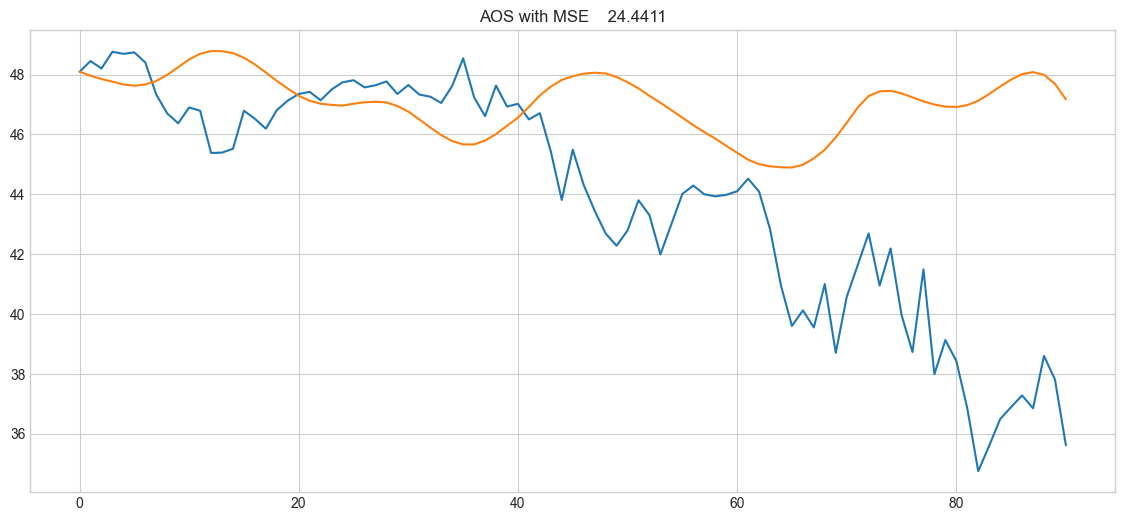

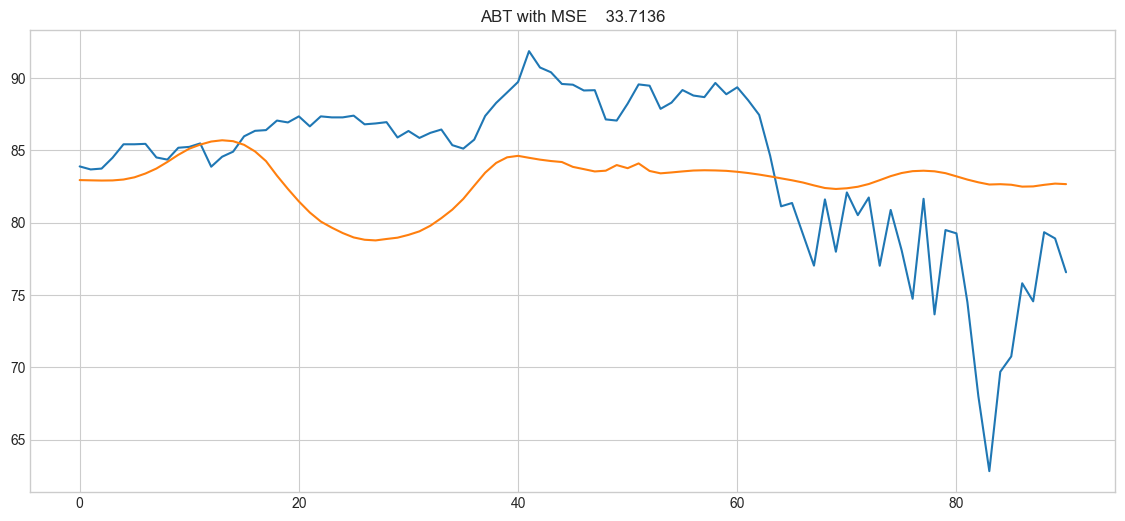

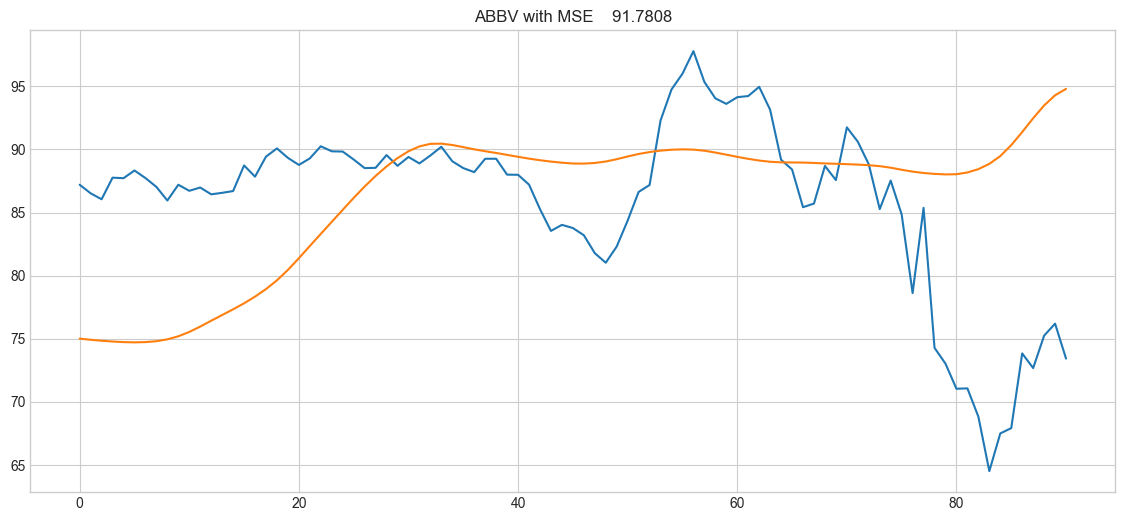

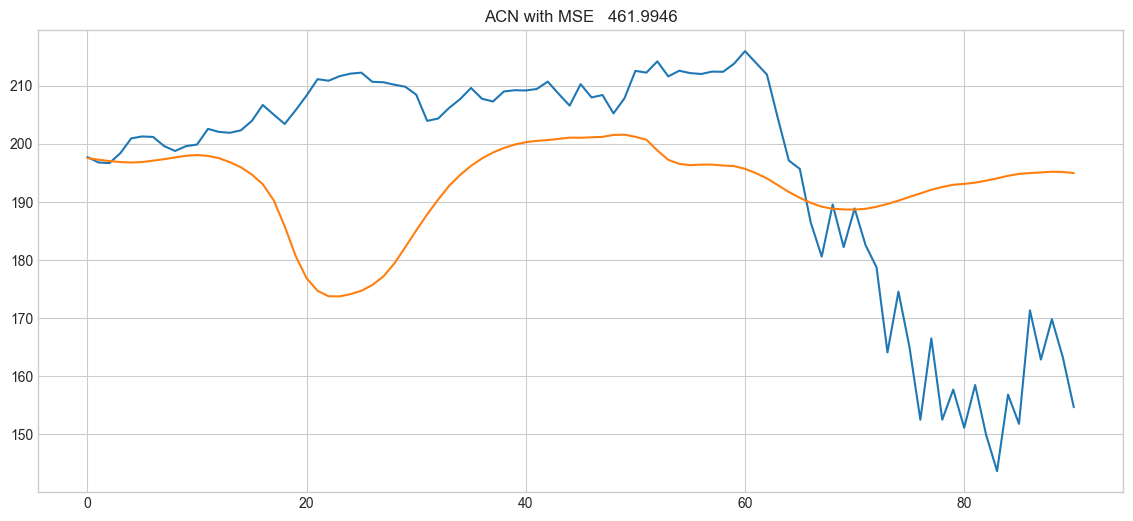

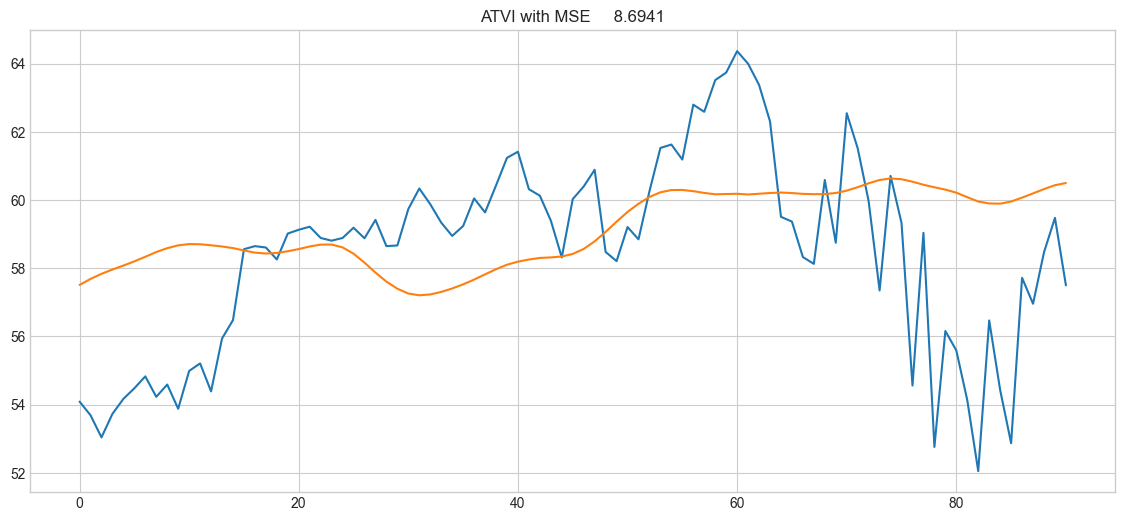

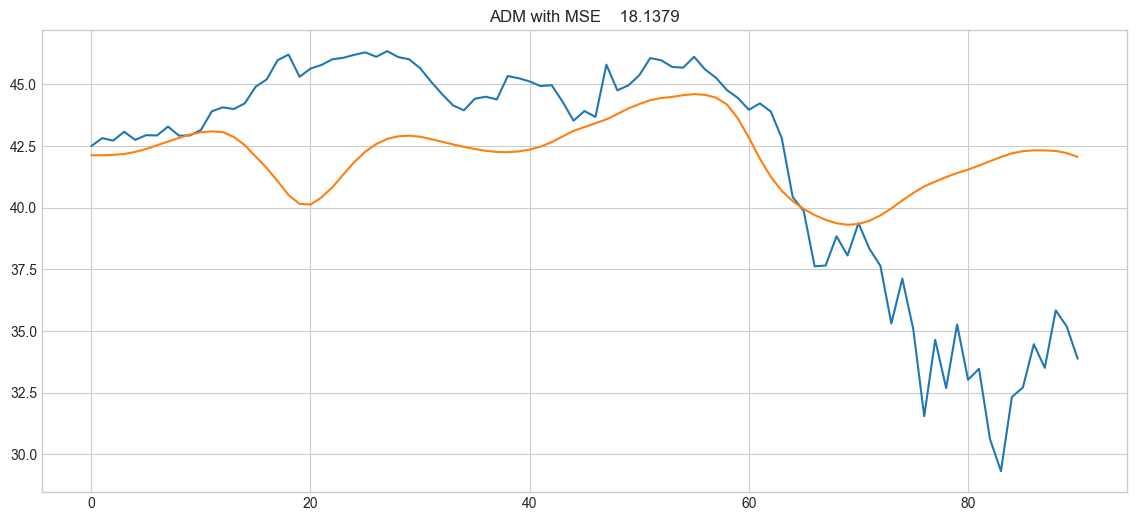

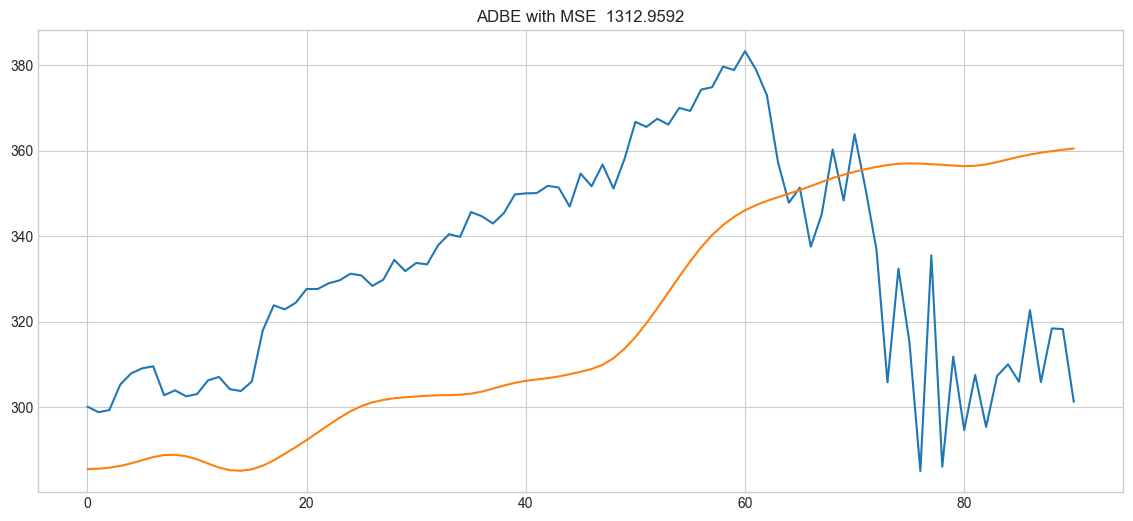

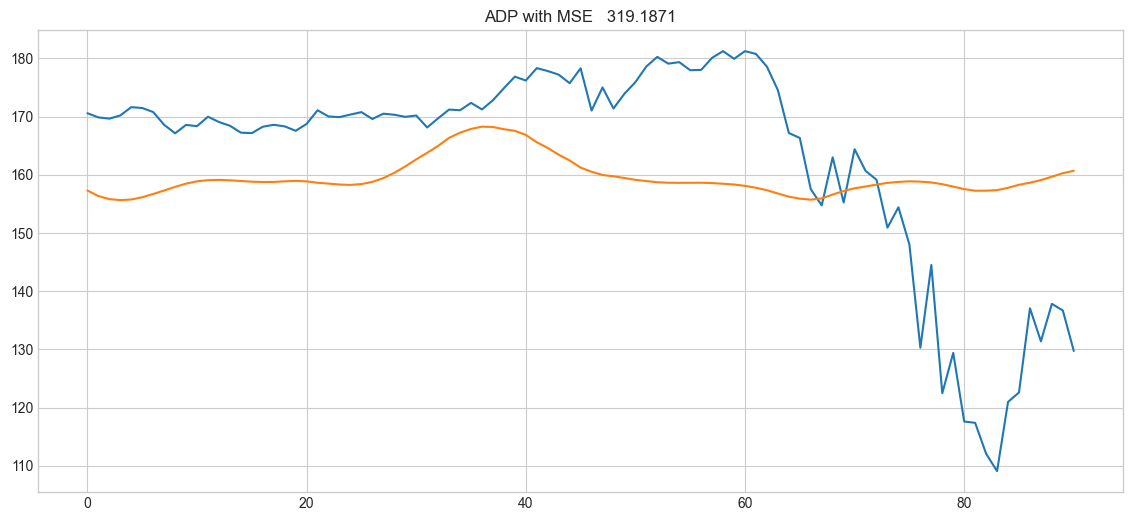

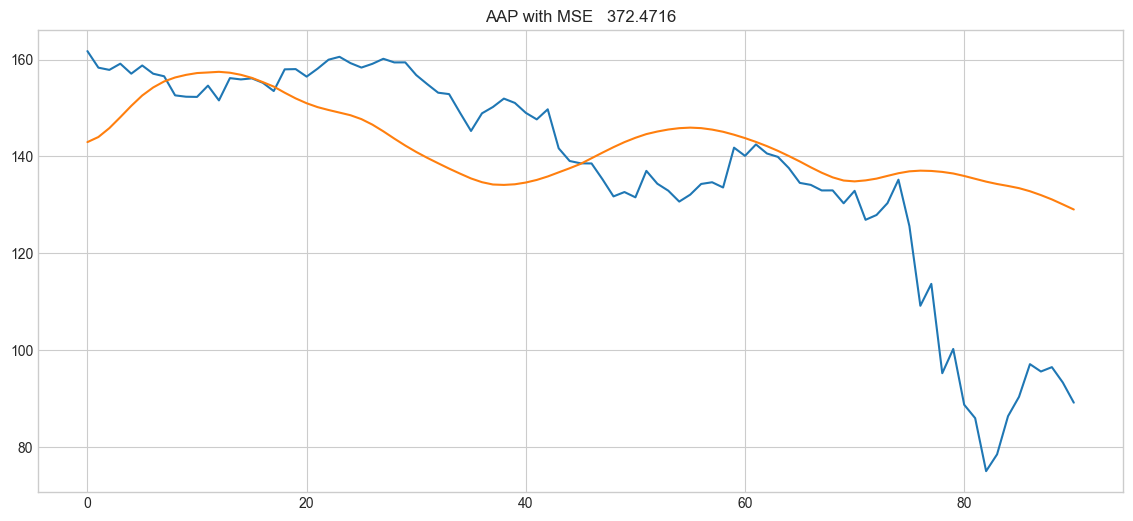

In [52]:
pred_result = {}
for i in stockList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

In [82]:
def lagging(df, lag, look_back, look_forward, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)

    df_pred_lag = df_pred.shift(lag)
    
    # Trim data to include only the desired look_back and look_forward periods
    df_pred_lag = df_pred_lag.iloc[look_back:-look_forward]
    df_true = df_true.iloc[look_back:-look_forward]
    df_pred = df_pred.iloc[look_back:-look_forward]

    print("MSE without Lag:", mean_squared_error(np.array(df_true), np.array(df_pred)))
    print("MSE with Lag:", mean_squared_error(np.array(df_true), np.array(df_pred_lag)))

    plt.figure(figsize=(14,4))
    plt.title("Prediction without Lag")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.plot(df_true)
    plt.plot(df_pred)

    MSE_lag = mean_squared_error(np.array(df_true), np.array(df_pred_lag))
    plt.figure(figsize=(14,4))
    plt.title(f"Prediction with Lag ({lag} days)")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.plot(df_true)
    plt.plot(df_pred_lag)
    plt.show()

    return df_pred_lag


Index(['2019-10-09', '2019-10-10', '2019-10-11', '2019-10-14', '2019-10-15',
       '2019-10-16', '2019-10-17', '2019-10-18', '2019-10-21', '2019-10-22',
       ...
       '2020-03-19', '2020-03-20', '2020-03-23', '2020-03-24', '2020-03-25',
       '2020-03-26', '2020-03-27', '2020-03-30', '2020-03-31', '2020-04-01'],
      dtype='object', name='Date', length=121)

In [85]:

# adjust the length of the time index
time_index = df_new["MMM"]["Test"][look_back:].index


# pass the adjusted time index to the lagging function

lagging(pred_result["MMM"], -5, look_back, look_forward, time_index)


ValueError: Length of values (91) does not match length of index (121)